# U.K. Traffic Accidents — Data Analysis

# Jo_notebook

In [165]:
# Import Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import requests
import time

In [166]:
#load csv data into dataframe, and combine date + time columns
working_df = pd.read_csv("cleaned_car_accidents.csv" , parse_dates=[["Date" , "Time"]])
#print first 5 rows to check dataframe worked
working_df.head()

,Date_Time,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),1st_Road_Class,...,Vehicle_Reference_y,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Car_Passenger,Casualty_Type,Casualty_Home_Area_Type
0,01/01/2005 20:23,200520D002602,-1.832342,52.534986,2,1,3,7,300,5,...,1,1,1,1,-1,-1,3,0,9,1
1,02/01/2005 18:45,200520D002703,-1.846293,52.465961,3,2,2,1,300,5,...,2,1,1,1,31,6,3,0,9,1
2,03/01/2005 17:04,200520D004203,-1.794089,52.455003,3,1,1,2,300,3,...,1,1,1,1,24,5,3,0,9,1
3,05/01/2005 15:05,200520D004603,-1.869954,52.478755,1,1,2,4,300,6,...,1,1,3,1,31,6,1,0,0,1
4,05/01/2005 22:00,200520D006503,-1.857470,52.469211,3,2,1,4,300,6,...,2,1,1,2,22,5,3,0,9,1


# Assessment of Casualty Numbers versus Time of Day

# Question: When are accidents most likely to occur, based on time of day?

### Here, we have filtered the data by combining accidents that have occurred during specific times of day into intervals, such that we can better assess when accidents are most likely to occur.

    A 24 hour time format is being used. The intervals we have decided are as follows:
    
    Morning - 06:00 - 11:59
    Afternoon - 12:00 - 17:59
    Evening- 18:00-23:59
    Night- 00:00 - 05:59

In [167]:
#check column names for use throughout analysis
working_df.columns

Index(['Date_Time', 'Accident_Index', 'Longitude', 'Latitude',
       'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties',
       'Day_of_Week', 'Local_Authority_(District)', '1st_Road_Class',
       '1st_Road_Number', 'Road_Type', 'Speed_limit', 'Junction_Detail',
       'Junction_Control', '2nd_Road_Class', '2nd_Road_Number',
       'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Vehicle_Reference_x', 'Vehicle_Type',
       'Towing_and_Articulation', 'Vehicle_Manoeuvre',
       'Vehicle_Location-Restricted_Lane', 'Junction_Location',
       'Skidding_and_Overturning', 'Hit_Object_in_Carriageway',
       'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway',
       '1st_Point_of_Impact', 'Journey_Purpose_of_Driver', 'Sex_of_Driver',
       'Age_of_Driver', 'Age_B

In [168]:
# Convert 'Date_Time' column to datetime objects
working_df['Date_Time'] = pd.to_datetime(working_df['Date_Time'], format="%d/%m/%Y %H:%M")

# Define the bins , label the bins and add the bins to dataframe
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
working_df['Time Bin'] = pd.cut(working_df['Date_Time'].dt.hour, bins=bins, labels=labels, right=False)

In [169]:
#Total number of accidents per bin
bar_df = working_df['Time Bin'].value_counts()
bar_df

Time Bin
Afternoon    29780
Evening      17658
Morning      16964
Night         3909
Name: count, dtype: int64

### The below pie chart shows that majority of accidents over the time period assessed, in the West Midlands, occur during afternoon hours of 12:00 - 17:59. Common knowledge tells us that this is usually the time of day when road users use their vehicles for school runs, and the evening commute home after work. Although we cannot infer whether these accidents are occurring specifically during the school run or the commute home, we can definitely recommend that further care should be taken when driving during these hours.

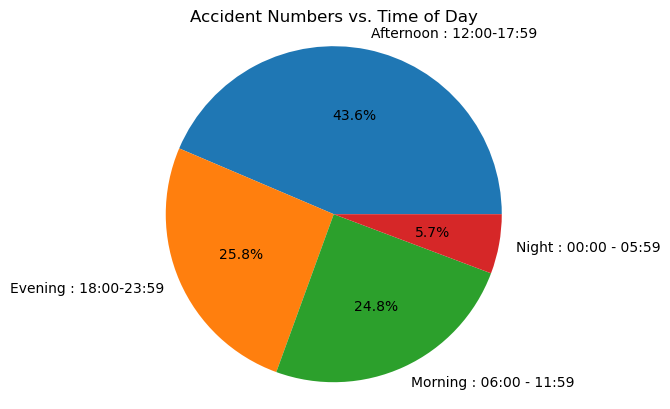

<Figure size 640x480 with 0 Axes>

In [170]:
#show relationship between time of day and number of accidents
labels = ['Afternoon : 12:00-17:59' , 'Evening : 18:00-23:59' , 'Morning : 06:00 - 11:59', 'Night : 00:00 - 05:59']
plt.pie(bar_df,labels=labels,autopct="%1.1f%%")
plt.title('Accident Numbers vs. Time of Day')
plt.axis("equal")
plt.show()

#save as png file
plt.savefig("visualisation/jo_pie_chart.png")

# Assessment of Casualty Severity based on Light Conditions

## Question: What type of light conditions contribute to the severity of casualties?

In the government data file, the road safety key has defined values in column **'Light_Conditions'** with the below keys-

    1 : Daylight
    4 : Darkness - lights lit
    5 : Darkness - lights unlit
    6 : Darkness - no lighting
    7 : Darkness - lighting unknown
    -1 : Data missing or out of range
 
It has also defined defined values in column **'Casualty_Severity'** with the below keys--

    1 : Fatal
    2 : Serious
    3 : Slight
    
We are going to combine the data under key 5 and 6, as both involve the roads being unlit. We will be dropping the data points from key 7 and -1 as this could potentially skew or create bias in our data because we do not know if the roads were lit or not.


In [171]:
#replace keys 5 or 6 with 5-6 combined
working_df['Light_Conditions'] = working_df['Light_Conditions'].replace({5: '5-6 Combined', 6: '5-6 Combined'})
#drop 7 and -1 key values
working_df = working_df[(working_df['Light_Conditions'] != 7) & (working_df['Light_Conditions'] != -1)]
working_df['Light_Conditions'].value_counts()

Light_Conditions
1               49196
4               18193
5-6 Combined      545
Name: count, dtype: int64

Light_Conditions
1               294
4               227
5-6 Combined     21
Name: count, dtype: int64
Light_Conditions
1               5265
4               2401
5-6 Combined      77
Name: count, dtype: int64
Light_Conditions
1               43637
4               15565
5-6 Combined      447
Name: count, dtype: int64


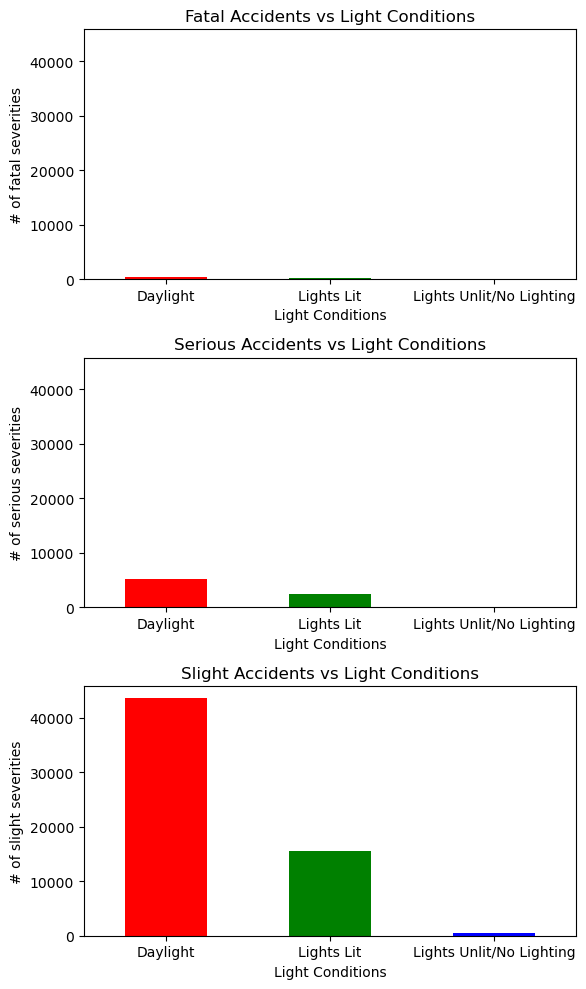

<Figure size 640x480 with 0 Axes>

In [172]:
# Define custom x-axis ticks
tick_names = ["Daylight", "Lights Lit", "Lights Unlit/No Lighting"]

# Create subplots
fig, axs = plt.subplots(3, figsize=(6, 10),sharey=True)

# For severity = fatal
working_df_fatal = working_df.loc[working_df["Casualty_Severity"] == 1]
working_fatal_light = working_df_fatal["Light_Conditions"].value_counts()
print(working_fatal_light)

#fatal vs light conditions plot
plot_1 = working_fatal_light.plot.bar(ax=axs[0],color=['red', 'green', 'blue'])
axs[0].set(xlabel="Light Conditions", ylabel="# of fatal severities", title = 'Fatal Accidents vs Light Conditions')

# Set custom x-axis ticks
axs[0].set_xticks(range(len(tick_names)))
axs[0].set_xticklabels(tick_names, rotation=0)

# For severity = serious
working_df_serious = working_df.loc[working_df["Casualty_Severity"] == 2]
working_serious_light = working_df_serious["Light_Conditions"].value_counts()
print(working_serious_light)

#serious vs light conditions plot
plot_2 = working_serious_light.plot.bar(ax=axs[1],color=['red', 'green', 'blue'])
axs[1].set(xlabel="Light Conditions", ylabel="# of serious severities", title = 'Serious Accidents vs Light Conditions')

# Set custom x-axis ticks
axs[1].set_xticks(range(len(tick_names)))
axs[1].set_xticklabels(tick_names, rotation=0)

# For severity = slight
working_df_slight = working_df.loc[working_df["Casualty_Severity"] == 3]
working_slight_light = working_df_slight["Light_Conditions"].value_counts()
print(working_slight_light)

#slight vs light conditions plot
plot_3 = working_slight_light.plot.bar(ax=axs[2],color=['red', 'green', 'blue'])
axs[2].set(xlabel="Light Conditions", ylabel="# of slight severities", title = 'Slight Accidents vs Light Conditions')

# Set custom x-axis ticks
axs[2].set_xticks(range(len(tick_names)))
axs[2].set_xticklabels(tick_names, rotation=0)

# Customize the overall plot
plt.tight_layout()

# Show the subplots
plt.show()

#Save the subplot
plt.savefig("visualisation/jo_sub_plot.png")

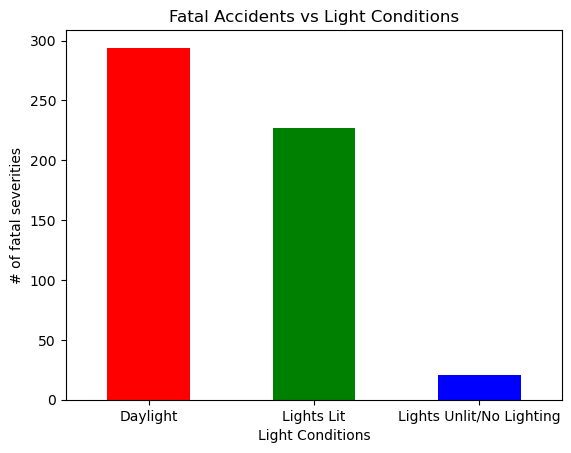

<Figure size 640x480 with 0 Axes>

In [173]:
tick_names = ["Daylight", "Lights Lit", "Lights Unlit/No Lighting"]

#fatal vs light conditions plot
plot_4 = working_fatal_light.plot.bar(working_fatal_light,color=['red', 'green', 'blue'])
plot_4.set(xlabel="Light Conditions", ylabel="# of fatal severities", title = 'Fatal Accidents vs Light Conditions')
plot_4.set_xticks(range(len(tick_names)))
plot_4.set_xticklabels(tick_names, rotation=0)

plt.show()
#Save the plot
plt.savefig("visualisation/jo_bar_plot.png")

# Can journey reasons explain the above information?

## Question: why are most accidents happening in the daylight, then?

### From the above bar plots, one can clearly see that accidents are happening when the roads are lit with daylight. This seems strange so we thought we would investigate this further. We wanted to see what the journey purpose was, as if most people are having accidents in the daylight hours, we would expect them to be doing school runs, work commutes etc.

The government data key shows the following, for values in column **'Journey_Purpose_of_Driver'**:

	1 : Journey as part of work vehicles
	2 : Commuting to/from work vehicles
	3 : Taking pupil to/from school vehicles
	4 : Pupil riding to/from school vehicles
	5 : Other vehicles
	6 : Not known vehicles
	15 : Other/Not known (2005-10) vehicles
    -1 : Data missing or out of range vehicles

Journey_Purpose_of_Driver
1     12055
2      5648
3       938
4       188
6     14794
15    34311
dtype: int64


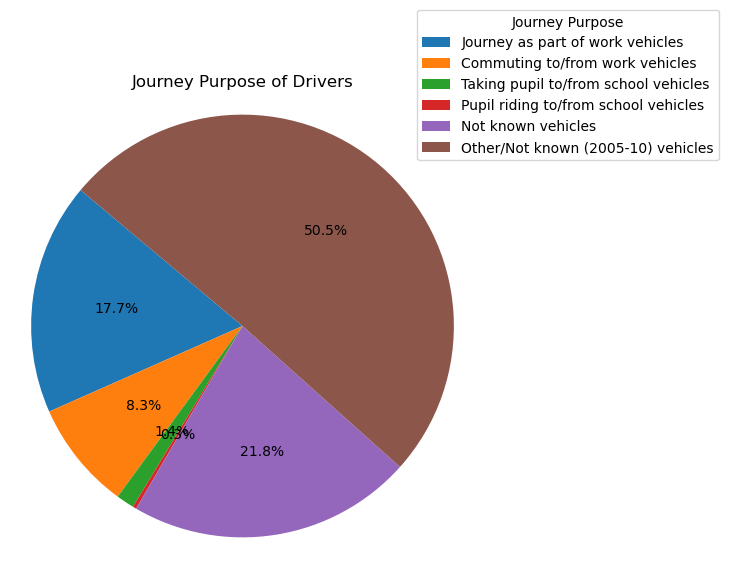

<Figure size 640x480 with 0 Axes>

In [174]:
#Find out how many journey purposes there are and their counts

journey_purpose = working_df.groupby(working_df['Journey_Purpose_of_Driver']).size()
print(journey_purpose)

#Start pie plotting
plt.figure(figsize=(6, 6))

# Map the current labels to the government labels
label_mapping = {
    1: 'Journey as part of work vehicles',
    2: 'Commuting to/from work vehicles',
    3: 'Taking pupil to/from school vehicles',
    4: 'Pupil riding to/from school vehicles',
    5: 'Other vehicles',
    6: 'Not known vehicles',
    15: 'Other/Not known (2005-10) vehicles',
    -1: 'Data missing or out of range vehicles'
}

# Replace the current labels with the new labels
journey_purpose.index = [label_mapping[label] for label in journey_purpose.index]
journey_plot = plt.pie(journey_purpose,autopct="%1.1f%%", startangle=140, radius=5)

#format pie plot
plt.title('Journey Purpose of Drivers')
plt.axis("equal")
plt.legend(journey_purpose.index, title="Journey Purpose", bbox_to_anchor=(1.2,1.2), loc="upper center")
plt.show()

#Save the plot
plt.savefig("visualisation/jo_journey_plot.png")

# Habib_notebook

In [175]:
# Import Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

In [176]:
# Load the dataset from a CSV file named "cleaned_car_accidents.csv" into a DataFrame named "Accidents"
Accidents = pd.read_csv("cleaned_car_accidents.csv")

# Display the first few rows of the "Accidents" DataFrame to understand data
Accidents.head()

,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),...,Vehicle_Reference_y,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Car_Passenger,Casualty_Type,Casualty_Home_Area_Type
0,200520D002602,-1.832342,52.534986,2,1,3,01/01/2005,7,20:23,300,...,1,1,1,1,-1,-1,3,0,9,1
1,200520D002703,-1.846293,52.465961,3,2,2,02/01/2005,1,18:45,300,...,2,1,1,1,31,6,3,0,9,1
2,200520D004203,-1.794089,52.455003,3,1,1,03/01/2005,2,17:04,300,...,1,1,1,1,24,5,3,0,9,1
3,200520D004603,-1.869954,52.478755,1,1,2,05/01/2005,4,15:05,300,...,1,1,3,1,31,6,1,0,0,1
4,200520D006503,-1.857470,52.469211,3,2,1,05/01/2005,4,22:00,300,...,2,1,1,2,22,5,3,0,9,1


In [177]:
# Convert the "Date" column to datetime format using the specified format '%d/%m/%Y' and display

Accidents['Date'] = pd.to_datetime(Accidents['Date'], format='%d/%m/%Y')

Accidents

,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),...,Vehicle_Reference_y,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Car_Passenger,Casualty_Type,Casualty_Home_Area_Type
0,200520D002602,-1.832342,52.534986,2,1,3,2005-01-01,7,20:23,300,...,1,1,1,1,-1,-1,3,0,9,1
1,200520D002703,-1.846293,52.465961,3,2,2,2005-01-02,1,18:45,300,...,2,1,1,1,31,6,3,0,9,1
2,200520D004203,-1.794089,52.455003,3,1,1,2005-01-03,2,17:04,300,...,1,1,1,1,24,5,3,0,9,1
3,200520D004603,-1.869954,52.478755,1,1,2,2005-01-05,4,15:05,300,...,1,1,3,1,31,6,1,0,0,1
4,200520D006503,-1.857470,52.469211,3,2,1,2005-01-05,4,22:00,300,...,2,1,1,2,22,5,3,0,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68306,201420Z500064,-1.937139,52.552170,3,1,1,2014-12-21,1,18:05,305,...,1,1,3,1,44,7,3,0,0,1
68307,201420Z500084,-1.852342,52.505975,3,2,3,2014-12-23,3,18:30,300,...,1,1,1,1,28,6,3,0,9,1
68308,201420Z500104,-1.860138,52.509850,3,2,1,2014-12-28,1,16:45,300,...,2,1,1,2,54,8,3,0,9,1
68309,201420Z500244,-1.871192,52.509054,3,2,2,2014-09-04,5,09:20,300,...,1,1,1,1,40,7,3,0,19,-1


In [178]:
# Use the 'list()' function to convert the columns of the DataFrame into a list and display list

list(Accidents.columns)

['Accident_Index',
 'Longitude',
 'Latitude',
 'Accident_Severity',
 'Number_of_Vehicles',
 'Number_of_Casualties',
 'Date',
 'Day_of_Week',
 'Time',
 'Local_Authority_(District)',
 '1st_Road_Class',
 '1st_Road_Number',
 'Road_Type',
 'Speed_limit',
 'Junction_Detail',
 'Junction_Control',
 '2nd_Road_Class',
 '2nd_Road_Number',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Carriageway_Hazards',
 'Urban_or_Rural_Area',
 'Vehicle_Reference_x',
 'Vehicle_Type',
 'Towing_and_Articulation',
 'Vehicle_Manoeuvre',
 'Vehicle_Location-Restricted_Lane',
 'Junction_Location',
 'Skidding_and_Overturning',
 'Hit_Object_in_Carriageway',
 'Vehicle_Leaving_Carriageway',
 'Hit_Object_off_Carriageway',
 '1st_Point_of_Impact',
 'Journey_Purpose_of_Driver',
 'Sex_of_Driver',
 'Age_of_Driver',
 'Age_Band_of_Driver',
 'Engine_Capacity_(CC)',
 'Age_of_Vehicle',
 'Driver

In [179]:
# Use the 'info()' method to display concise information about the DataFrame, to show the Data type.

Accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68311 entries, 0 to 68310
Data columns (total 55 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Accident_Index                           68311 non-null  object        
 1   Longitude                                68311 non-null  float64       
 2   Latitude                                 68311 non-null  float64       
 3   Accident_Severity                        68311 non-null  int64         
 4   Number_of_Vehicles                       68311 non-null  int64         
 5   Number_of_Casualties                     68311 non-null  int64         
 6   Date                                     68311 non-null  datetime64[ns]
 7   Day_of_Week                              68311 non-null  int64         
 8   Time                                     68311 non-null  object        
 9   Local_Authority_(District)             

In [180]:
#method to check missing values in the DataFrame.

Accidents.isnull().sum()

Accident_Index                             0
Longitude                                  0
Latitude                                   0
Accident_Severity                          0
Number_of_Vehicles                         0
Number_of_Casualties                       0
Date                                       0
Day_of_Week                                0
Time                                       0
Local_Authority_(District)                 0
1st_Road_Class                             0
1st_Road_Number                            0
Road_Type                                  0
Speed_limit                                0
Junction_Detail                            0
Junction_Control                           0
2nd_Road_Class                             0
2nd_Road_Number                            0
Pedestrian_Crossing-Human_Control          0
Pedestrian_Crossing-Physical_Facilities    0
Light_Conditions                           0
Weather_Conditions                         0
Road_Surfa

In [181]:
#Uses the 'describe' method to generate descriptive statistics for the numeric columns in the DataFrame.

Accidents.describe()

,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Local_Authority_(District),1st_Road_Class,1st_Road_Number,...,Vehicle_Reference_y,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Car_Passenger,Casualty_Type,Casualty_Home_Area_Type
count,68311.000000,68311.000000,68311.000000,68311.000000,68311.000000,68311,68311.000000,68311.000000,68311.000000,68311.000000,...,68311.000000,68311.000000,68311.000000,68311.000000,68311.000000,68311.000000,68311.000000,68311.000000,68311.000000,68311.000000
mean,-1.897209,52.492207,2.856451,1.850288,1.371624,2009-05-28 14:11:55.773448192,4.118678,302.792786,4.463161,1268.857007,...,1.470232,1.026496,1.551068,1.392250,32.474389,5.764899,2.870343,0.125836,6.496289,0.940449
min,-2.203214,52.348078,1.000000,1.000000,1.000000,2005-01-01 00:00:00,1.000000,300.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000,-1.000000
25%,-2.013377,52.447660,3.000000,1.000000,1.000000,2006-12-10 00:00:00,2.000000,300.000000,3.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,20.000000,4.000000,3.000000,0.000000,1.000000,1.000000
50%,-1.910877,52.485477,3.000000,2.000000,1.000000,2009-01-13 00:00:00,4.000000,302.000000,4.000000,34.000000,...,1.000000,1.000000,1.000000,1.000000,29.000000,6.000000,3.000000,0.000000,9.000000,1.000000
75%,-1.830438,52.531750,3.000000,2.000000,1.000000,2011-09-21 00:00:00,6.000000,305.000000,6.000000,4040.000000,...,2.000000,1.000000,2.000000,2.000000,44.000000,7.000000,3.000000,0.000000,9.000000,1.000000
max,-1.428223,52.662124,3.000000,12.000000,42.000000,2014-12-31 00:00:00,7.000000,309.000000,6.000000,5127.000000,...,9.000000,6.000000,3.000000,2.000000,100.000000,11.000000,3.000000,2.000000,90.000000,3.000000
std,0.172846,0.060632,0.376019,0.670148,0.817911,NaN,1.924740,3.099256,1.497184,1871.996418,...,0.528104,0.206966,0.823011,0.488256,18.517720,2.484937,0.358852,0.413438,6.727738,0.534120


In [182]:
# Group the "Accidents" DataFrame by the "Accident_Severity" column and count the number of occurrences of each severity level.
# This creates a Series that represents the count of accidents for each severity level.

Accident_bar = Accidents.groupby(["Accident_Severity"])["Accident_Index"].count()

# Display the first few rows of the resulting Series using the 'head()' method.
Accident_bar.head()

Accident_Severity
1      630
2     8546
3    59135
Name: Accident_Index, dtype: int64

In [183]:
# Create a new DataFrame named "Accident_high" by filtering the original "Accidents" DataFrame.
# The filter selects rows where the "Accident_Severity" column has a value of 1 "Fatal", indicating high severity accidents.

Accident_high = Accidents.loc[Accidents["Accident_Severity"]==1,:]

Accident_high

,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),...,Vehicle_Reference_y,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Car_Passenger,Casualty_Type,Casualty_Home_Area_Type
3,200520D004603,-1.869954,52.478755,1,1,2,2005-01-05,4,15:05,300,...,1,1,3,1,31,6,1,0,0,1
51,200520D021503,-1.812290,52.500614,1,2,2,2005-01-14,6,22:40,300,...,2,1,2,2,63,9,1,1,9,1
196,200520D054801,-1.843362,52.503895,1,1,4,2005-02-18,6,21:58,300,...,1,1,1,1,20,4,1,0,9,1
259,200520D073803,-1.803951,52.487654,1,2,1,2005-03-09,4,17:40,300,...,1,1,3,1,32,6,1,0,0,1
349,200520D099202,-1.824836,52.568778,1,1,1,2005-04-02,7,16:33,300,...,1,1,3,1,93,11,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67788,201420W046864,-1.902716,52.511961,1,1,1,2014-10-17,6,22:27,300,...,1,1,1,1,58,9,1,0,9,1
67848,201420W052054,-1.917200,52.488777,1,1,1,2014-11-17,2,04:05,300,...,1,1,3,1,41,7,1,0,0,1
68127,201420Z001254,-2.014285,52.586347,1,2,1,2014-03-16,1,06:25,307,...,1,1,1,1,19,4,1,0,9,1
68185,201420Z002344,-1.733528,52.492372,1,2,3,2014-07-06,1,04:57,306,...,1,1,1,1,33,6,3,0,9,-1


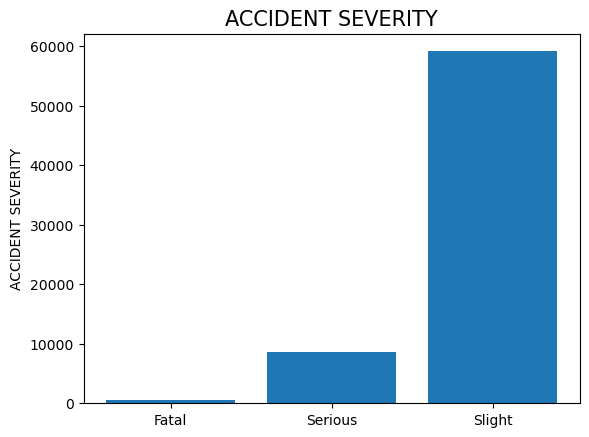

<Figure size 640x480 with 0 Axes>

In [184]:
# Group the "Accidents" DataFrame by the "Accident_Severity" column and count the number of occurrences of each severity level.

Accident_bar = Accidents.groupby(["Accident_Severity"])["Accident_Index"].count()

Accident_bar.head()

# Get the index (severity levels) of the Series.

Accident_bar.index

# Create a bar chart to visualize accident severity levels.

# The x-axis labels are set to ['Fatal', 'Serious', 'Slight'] and the corresponding counts are used for the y-axis.

plt.bar(['Fatal','Serious','Slight'], Accident_bar)

# Set the title and labels for the chart. Show bar chart
plt.title('ACCIDENT SEVERITY', fontsize=15)
plt.ylabel('ACCIDENT SEVERITY')
plt.show()

#Save the plot
plt.savefig("visualisation/habib_accident_severity.png")

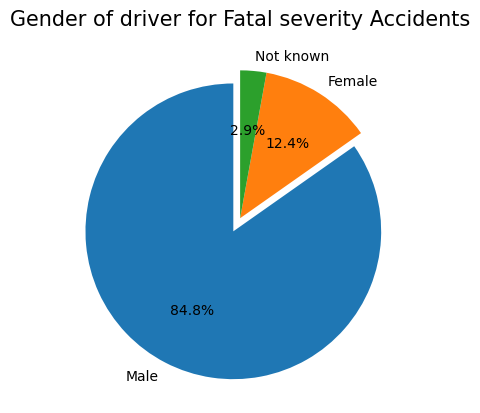

<Figure size 640x480 with 0 Axes>

In [185]:
# Create a new DataFrame named "Accident_high" by filtering the original "Accidents" DataFrame.
# The filter selects rows where the "Accident_Severity" column has a value of 1, indicating high severity accidents.

Accident_high = Accidents.loc[Accidents["Accident_Severity"]==1,:]

Accident_high

# Group the "Accident_high" DataFrame by the "Sex_of_Driver" column and count the number of occurrences of each gender/element.
Gender_count = Accident_high.groupby(["Sex_of_Driver"])["Sex_of_Driver"].count()

# Define labels for the pie chart segments, representing gender categories 
# Explode' parameter to emphasize a portion of the pie chart (0.1 for 'Male' segment).
# Define sizes based on the counts of high-severity accidents by gender.

Label = ["Male","Female","Not known"]
explode = (0.1,0,0)
sizes = Gender_count


# Create a pie chart using the specified sizes, labels, autopct format, explode settings, and start angle.

plt.pie(sizes,labels=Label,autopct="%1.1f%%",explode = explode,startangle = 90)

# Set the title for the pie chara and display the pie chart.

plt.title('Gender of driver for Fatal severity Accidents', fontsize=15)
plt.show()

#Save the plot
plt.savefig("visualisation/habib_Gender_of_driver_fatal.png")

In [186]:
# Group the "Accident_high" DataFrame by the "Age_Band_of_Driver" column and count the number of occurrences in each age band.

Age_count = Accident_high.groupby(["Age_Band_of_Driver"])["Age_Band_of_Driver"].count()

# Display Age count. 
Age_count

Age_Band_of_Driver
-1      33
 2       1
 3       3
 4      74
 5     111
 6     152
 7     122
 8      63
 9      36
 10     16
 11     19
Name: Age_Band_of_Driver, dtype: int64

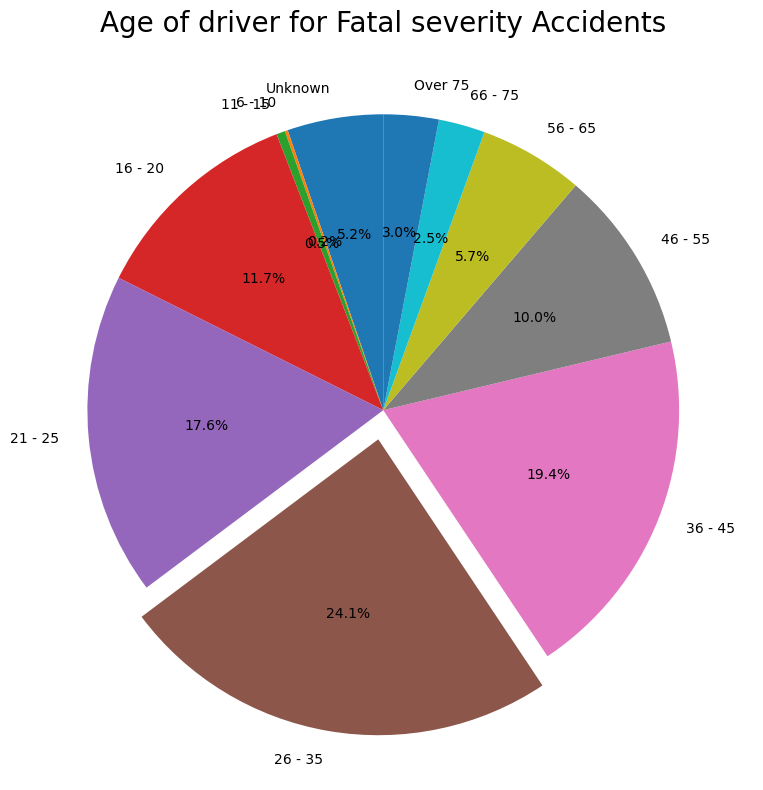

<Figure size 640x480 with 0 Axes>

In [187]:
# Create a new DataFrame named "Accident_high" by filtering the original "Accidents" DataFrame.
# The filter selects rows where the "Accident_Severity" column has a value of 1, indicating high severity accidents.

Accident_high = Accidents.loc[Accidents["Accident_Severity"]==1,:]

Accident_high

# Group the "Accident_high" DataFrame by the "Age_Band_of_Driver" column and count the number of occurrences in each age band.

Age_count = Accident_high.groupby(["Age_Band_of_Driver"])["Age_Band_of_Driver"].count()

# Extract the unique age bands from the "Age_Band_of_Driver" column in the "Accident_high" DataFrame.

unique_age_bands = Accident_high["Age_Band_of_Driver"].unique()

# Define labels, explode settings, sizes, and the figure size for a pie chart.
label = ["Unknown","6 - 10","11 - 15","16 - 20","21 - 25","26 - 35","36 - 45","46 - 55","56 - 65","66 - 75","Over 75"]
explode = (0,0,0,0,0,0.1,0,0,0,0,0)
sizes = Age_count
plt.figure(figsize=(8,8))

# Create a pie chart with specified sizes, labels, autopct format, explode settings, start angle, and text properties, and set the title.

plt.pie(sizes, labels = label ,autopct="%1.1f%%", explode = explode ,startangle = 90,textprops={"fontsize":10})

plt.title('Age of driver for Fatal severity Accidents', fontsize=20)
plt.tight_layout()
plt.show()

#Save the plot
plt.savefig("visualisation/habib_Age_of_driver_fatal.png")


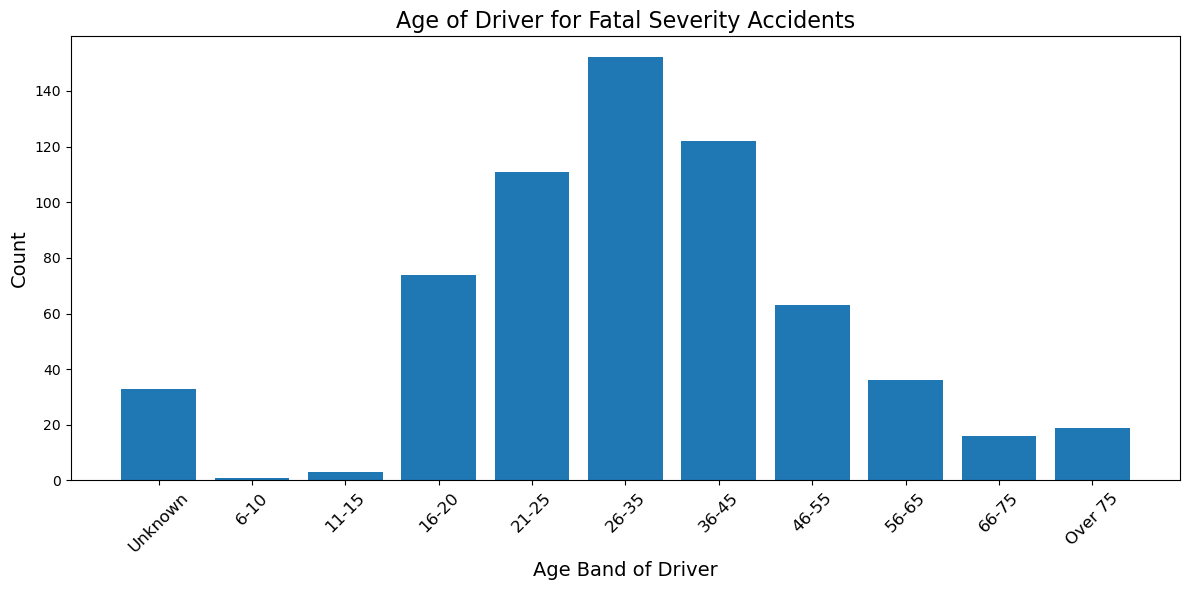

<Figure size 640x480 with 0 Axes>

In [188]:
# Group the "Accident_high" DataFrame by the "Age_Band_of_Driver" column and count the number of occurrences in each age band.
# Extract the unique age bands from the "Age_Band_of_Driver" column in the "Accident_high" DataFrame.
# Define a list of labels for age bands
Age_count = Accident_high.groupby(["Age_Band_of_Driver"])["Age_Band_of_Driver"].count()
unique_age_bands = Accident_high["Age_Band_of_Driver"].unique()
label = ["Unknown","6-10","11-15","16-20","21-25","26-35","36-45","46-55","56-65","66-75","Over 75"]

# Define x as a range representing the unique age bands and y as the corresponding counts of high-severity accidents.

x = range(len(unique_age_bands))
y = Age_count

# Create a bar chart with specified x and y values, labels, axis labels, title, and formatting settings.

plt.figure(figsize=(12, 6))
plt.bar(x, y, tick_label=label)


plt.xlabel('Age Band of Driver', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Age of Driver for Fatal Severity Accidents', fontsize=16)


plt.xticks(rotation=45, fontsize=12)


plt.tight_layout()
plt.show()

#Save the plot
plt.savefig("visualisation/habib_Age_of_driver_fatal_bar.png")

In [189]:
# Group the "Accident_high" DataFrame by the "Road_Type" column and count the number of occurrences for each road type.

RT_count = Accident_high.groupby(["Road_Type"])["Road_Type"].count()
RT_count

Road_Type
1     16
2      6
3    195
6    408
7      4
9      1
Name: Road_Type, dtype: int64

In [190]:
# Create a new DataFrame named "Gender_male" by filtering the "Accident_high" DataFrame.

# The filter selects rows where the "Sex_of_Driver" column has a value of 1, indicating male drivers.

Gender_male = Accident_high[Accident_high["Sex_of_Driver"]==1]

Gender_male

,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),...,Vehicle_Reference_y,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Car_Passenger,Casualty_Type,Casualty_Home_Area_Type
3,200520D004603,-1.869954,52.478755,1,1,2,2005-01-05,4,15:05,300,...,1,1,3,1,31,6,1,0,0,1
51,200520D021503,-1.812290,52.500614,1,2,2,2005-01-14,6,22:40,300,...,2,1,2,2,63,9,1,1,9,1
196,200520D054801,-1.843362,52.503895,1,1,4,2005-02-18,6,21:58,300,...,1,1,1,1,20,4,1,0,9,1
259,200520D073803,-1.803951,52.487654,1,2,1,2005-03-09,4,17:40,300,...,1,1,3,1,32,6,1,0,0,1
349,200520D099202,-1.824836,52.568778,1,1,1,2005-04-02,7,16:33,300,...,1,1,3,1,93,11,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67740,201420W042374,-1.924248,52.501188,1,1,1,2014-09-04,5,19:40,300,...,1,1,2,1,39,7,1,0,11,1
67788,201420W046864,-1.902716,52.511961,1,1,1,2014-10-17,6,22:27,300,...,1,1,1,1,58,9,1,0,9,1
68127,201420Z001254,-2.014285,52.586347,1,2,1,2014-03-16,1,06:25,307,...,1,1,1,1,19,4,1,0,9,1
68185,201420Z002344,-1.733528,52.492372,1,2,3,2014-07-06,1,04:57,306,...,1,1,1,1,33,6,3,0,9,-1


In [191]:
# Calculate the count of high-severity accidents involving male drivers and then print. 

male_high_severity_count = len(Gender_male)
print("High-severity accidents involving male drivers:", male_high_severity_count)

High-severity accidents involving male drivers: 534


In [192]:
# Create a new DataFrame named "Gender_female" by filtering the "Accident_high" DataFrame.

# The filter selects rows where the "Sex_of_Driver" column has a value of 2, indicating female drivers.

Gender_female = Accident_high[Accident_high["Sex_of_Driver"]==2]

Gender_female

,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),...,Vehicle_Reference_y,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Car_Passenger,Casualty_Type,Casualty_Home_Area_Type
865,200520D222201,-1.834053,52.511165,1,2,3,2005-07-26,3,21:04,300,...,1,2,1,2,60,9,2,0,9,1
1664,200520E007302,-1.884877,52.402534,1,1,1,2005-01-14,6,10:05,300,...,1,1,3,1,78,11,1,0,0,1
1781,200520E031602,-1.883543,52.406938,1,1,2,2005-02-21,2,14:16,300,...,1,1,1,2,78,11,2,0,9,1
2668,200520E200802,-1.903178,52.435454,1,1,1,2005-11-15,3,17:50,300,...,1,1,3,2,15,3,1,0,0,-1
2806,200520E230402,-1.836406,52.432953,1,1,2,2005-12-29,5,12:28,300,...,1,1,2,2,67,10,1,2,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63442,201420H007064,-1.902757,52.626763,1,3,4,2014-08-18,2,11:50,307,...,1,2,1,2,59,9,3,0,9,1
64102,201420J503544,-2.090948,52.543161,1,1,1,2014-11-14,6,15:00,303,...,1,1,2,2,87,11,1,2,10,1
64435,201420K010544,-1.986420,52.485209,1,2,5,2014-09-20,7,22:45,305,...,2,1,1,1,23,5,1,0,9,1
64899,201420L007314,-1.737489,52.420819,1,1,1,2014-12-22,2,16:43,306,...,1,1,3,1,57,9,1,0,0,2


In [193]:
# Calculate the count of high-severity accidents involving female drivers and then print. 

female_high_severity_count = len(Gender_female)
print("High-severity accidents involving male drivers:", female_high_severity_count)

High-severity accidents involving male drivers: 78


In [194]:
# Group the "Accident_high" DataFrame by the "Sex_of_Driver" column and count the number of occurrences for each gender.

Gender_count = Accident_high.groupby(["Sex_of_Driver"])["Sex_of_Driver"].count()
Gender_count

Sex_of_Driver
1    534
2     78
3     18
Name: Sex_of_Driver, dtype: int64

In [195]:
# Creation of "age_band_mapping" dictionary 

age_band_mapping = {
    -1: "Unknown",
    1: "0 - 5",
    2: "6 - 10",
    3: "11 - 15",
    4: "16 - 20",
    5: "21 - 25",
    6: "26 - 35",
    7: "36 - 45",
    8: "46 - 55",
    9: "56 - 65",
    10: "66 - 75",
    11: "Over 75"
}

# Map age bands to descriptive labels using the "age_band_mapping" dictionary for both male and female drivers.

Gender_male['Age_Band_of_Driver'] = Gender_male['Age_Band_of_Driver'].map(age_band_mapping)
Gender_female['Age_Band_of_Driver'] = Gender_female['Age_Band_of_Driver'].map(age_band_mapping)

C:\Users\HabibRehman\AppData\Local\Temp\ipykernel_28260\2793618004.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Gender_male['Age_Band_of_Driver'] = Gender_male['Age_Band_of_Driver'].map(age_band_mapping)
C:\Users\HabibRehman\AppData\Local\Temp\ipykernel_28260\2793618004.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Gender_female['Age_Band_of_Driver'] = Gender_female['Age_Band_of_Driver'].map(age_band_mapping)


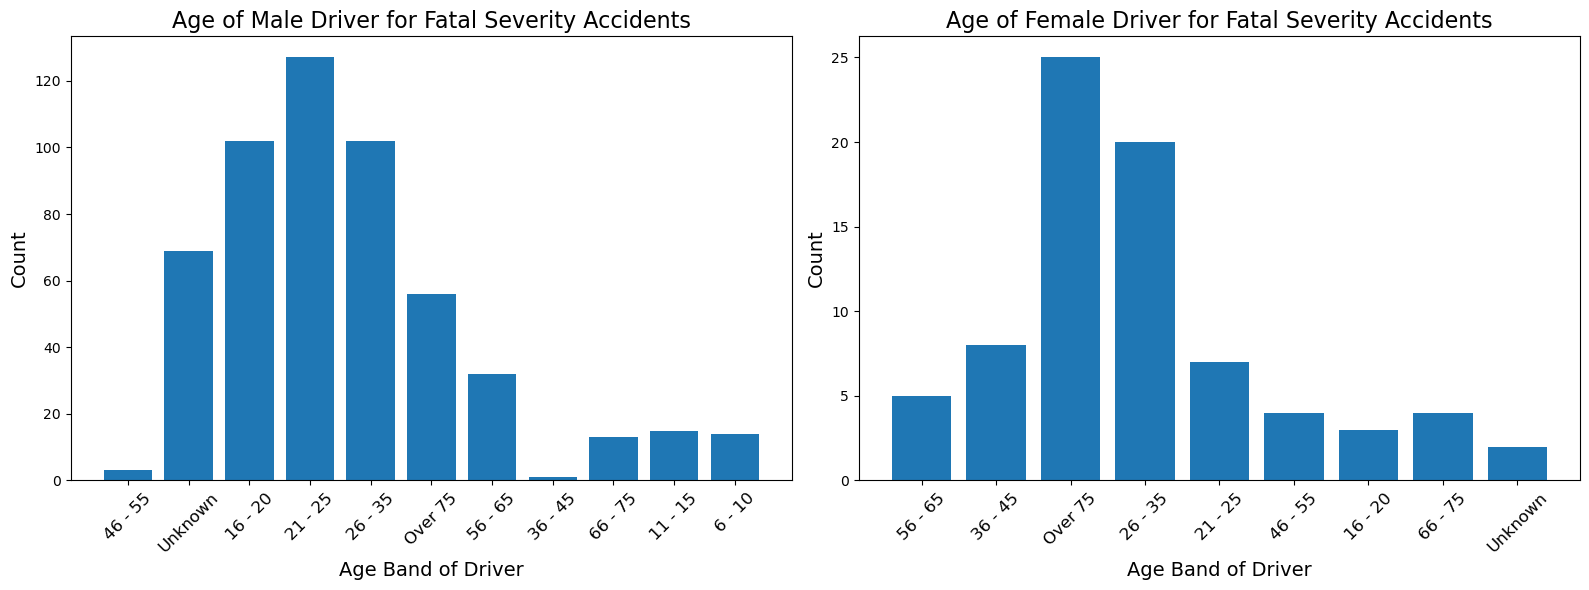

<Figure size 640x480 with 0 Axes>

In [196]:
# Create subplots for male and female drivers
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Create a function to plot age distribution for a given gender DataFrame
def plot_age_distribution(ax, df, gender_label):
    Age_count = df.groupby(["Age_Band_of_Driver"])["Age_Band_of_Driver"].count()
    unique_age_bands = df["Age_Band_of_Driver"].unique()
    # Mapping solution implemented 
    #label = ["Unknown","6-10","11-15","16-20","21-25","26-35","36-45","46-55","56-65","66-75","Over 75"]
    label = unique_age_bands.tolist()
  

    x = range(len(unique_age_bands))
    y = Age_count

    ax.bar(x, y, tick_label=label)
    ax.set_xlabel('Age Band of Driver', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.set_title(f'Age of {gender_label} Driver for Fatal Severity Accidents', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(label, rotation=45, fontsize=12)

# Plot age distribution for male drivers
plot_age_distribution(ax1, Gender_male, "Male")

# Plot age distribution for female drivers
plot_age_distribution(ax2, Gender_female, "Female")

plt.tight_layout()
plt.show()

#Save the plot
plt.savefig("visualisation/habib_dist_Age_band_of_gender_fatal_bar.png")

# Maliha_notebook

In [197]:
#Dependencies and Setup
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import requests 
import time
from datetime import datetime 
from scipy.stats import linregress

In [198]:
accident_uk_df=pd.read_csv("resources/cleaned_car_accidents.csv")

In [199]:
accident_uk_df.head()

,Unnamed: 0,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,...,Vehicle_Reference_y,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Car_Passenger,Casualty_Type,Casualty_Home_Area_Type
0,0,200520D002602,-1.832342,52.534986,2,1,3,01/01/2005,7,20:23,...,1,1,1,1,-1,-1,3,0,9,1
1,3,200520D002703,-1.846293,52.465961,3,2,2,02/01/2005,1,18:45,...,2,1,1,1,31,6,3,0,9,1
2,7,200520D004203,-1.794089,52.455003,3,1,1,03/01/2005,2,17:04,...,1,1,1,1,24,5,3,0,9,1
3,8,200520D004603,-1.869954,52.478755,1,1,2,05/01/2005,4,15:05,...,1,1,3,1,31,6,1,0,0,1
4,10,200520D006503,-1.857470,52.469211,3,2,1,05/01/2005,4,22:00,...,2,1,1,2,22,5,3,0,9,1


In [200]:
accident_uk_df.columns

Index(['Unnamed: 0', 'Accident_Index', 'Longitude', 'Latitude',
       'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties',
       'Date', 'Day_of_Week', 'Time', 'Local_Authority_(District)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Vehicle_Reference_x', 'Vehicle_Type',
       'Towing_and_Articulation', 'Vehicle_Manoeuvre',
       'Vehicle_Location-Restricted_Lane', 'Junction_Location',
       'Skidding_and_Overturning', 'Hit_Object_in_Carriageway',
       'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway',
       '1st_Point_of_Impact', 'Journey_Purpose_of_Driver', 'Sex_of_Driver',
       'Age_o

In [201]:
#calculating the total number of accidents
accident_counts = accident_uk_df.groupby('Accident_Index').size()
accident_counts.count()

68311

In [202]:
accident_uk_df['Date']

0        01/01/2005
1        02/01/2005
2        03/01/2005
3        05/01/2005
4        05/01/2005
            ...    
68306    21/12/2014
68307    23/12/2014
68308    28/12/2014
68309    04/09/2014
68310    07/05/2014
Name: Date, Length: 68311, dtype: object

In [203]:
#adjusting the date format to datetime
accident_uk_df['Date'] = pd.to_datetime(accident_uk_df['Date'], format='%d/%m/%Y')
accident_uk_df

,Unnamed: 0,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,...,Vehicle_Reference_y,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Car_Passenger,Casualty_Type,Casualty_Home_Area_Type
0,0,200520D002602,-1.832342,52.534986,2,1,3,2005-01-01,7,20:23,...,1,1,1,1,-1,-1,3,0,9,1
1,3,200520D002703,-1.846293,52.465961,3,2,2,2005-01-02,1,18:45,...,2,1,1,1,31,6,3,0,9,1
2,7,200520D004203,-1.794089,52.455003,3,1,1,2005-01-03,2,17:04,...,1,1,1,1,24,5,3,0,9,1
3,8,200520D004603,-1.869954,52.478755,1,1,2,2005-01-05,4,15:05,...,1,1,3,1,31,6,1,0,0,1
4,10,200520D006503,-1.857470,52.469211,3,2,1,2005-01-05,4,22:00,...,2,1,1,2,22,5,3,0,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68306,181826,201420Z500064,-1.937139,52.552170,3,1,1,2014-12-21,1,18:05,...,1,1,3,1,44,7,3,0,0,1
68307,181827,201420Z500084,-1.852342,52.505975,3,2,3,2014-12-23,3,18:30,...,1,1,1,1,28,6,3,0,9,1
68308,181833,201420Z500104,-1.860138,52.509850,3,2,1,2014-12-28,1,16:45,...,2,1,1,2,54,8,3,0,9,1
68309,181835,201420Z500244,-1.871192,52.509054,3,2,2,2014-09-04,5,09:20,...,1,1,1,1,40,7,3,0,19,-1


In [204]:
#changing the format of the date and assigning start_date and end_date variables to keep the dates to filter the data 
#for 5 years duration 
start_date = datetime(2010,1,1)
end_date = datetime(2014,12,31)
year_df=accident_uk_df[(accident_uk_df['Date']>=start_date) & (accident_uk_df['Date']<=end_date)]
year_df

,Unnamed: 0,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,...,Vehicle_Reference_y,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Car_Passenger,Casualty_Type,Casualty_Home_Area_Type
41202,109010,201020D002713,-1.761121,52.482901,3,2,2,2010-01-03,1,14:30,...,2,1,1,2,18,4,3,0,9,1
41203,109014,201020D004613,-1.854218,52.473343,3,2,1,2010-01-02,7,22:05,...,2,1,2,1,27,6,3,0,10,1
41204,109016,201020D006113,-1.843905,52.475397,3,1,1,2010-01-04,2,23:11,...,1,1,3,1,31,6,3,0,0,1
41205,109017,201020D006513,-1.828907,52.470252,3,2,1,2010-01-04,2,13:30,...,2,1,1,1,63,9,3,0,9,1
41206,109019,201020D006913,-1.815186,52.477604,3,2,2,2010-01-05,3,16:30,...,2,1,1,1,39,7,3,0,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68306,181826,201420Z500064,-1.937139,52.552170,3,1,1,2014-12-21,1,18:05,...,1,1,3,1,44,7,3,0,0,1
68307,181827,201420Z500084,-1.852342,52.505975,3,2,3,2014-12-23,3,18:30,...,1,1,1,1,28,6,3,0,9,1
68308,181833,201420Z500104,-1.860138,52.509850,3,2,1,2014-12-28,1,16:45,...,2,1,1,2,54,8,3,0,9,1
68309,181835,201420Z500244,-1.871192,52.509054,3,2,2,2014-09-04,5,09:20,...,1,1,1,1,40,7,3,0,19,-1


In [205]:
severity_mapping = {1: 'Fatal', 2: 'Serious', 3: 'Slight'}

# Apply the mapping using replace()
year_df['Accident_Severity'] = year_df['Accident_Severity'].replace(severity_mapping)
year_df

C:\Users\HabibRehman\AppData\Local\Temp\ipykernel_28260\1463771917.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df['Accident_Severity'] = year_df['Accident_Severity'].replace(severity_mapping)


,Unnamed: 0,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,...,Vehicle_Reference_y,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Car_Passenger,Casualty_Type,Casualty_Home_Area_Type
41202,109010,201020D002713,-1.761121,52.482901,Slight,2,2,2010-01-03,1,14:30,...,2,1,1,2,18,4,3,0,9,1
41203,109014,201020D004613,-1.854218,52.473343,Slight,2,1,2010-01-02,7,22:05,...,2,1,2,1,27,6,3,0,10,1
41204,109016,201020D006113,-1.843905,52.475397,Slight,1,1,2010-01-04,2,23:11,...,1,1,3,1,31,6,3,0,0,1
41205,109017,201020D006513,-1.828907,52.470252,Slight,2,1,2010-01-04,2,13:30,...,2,1,1,1,63,9,3,0,9,1
41206,109019,201020D006913,-1.815186,52.477604,Slight,2,2,2010-01-05,3,16:30,...,2,1,1,1,39,7,3,0,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68306,181826,201420Z500064,-1.937139,52.552170,Slight,1,1,2014-12-21,1,18:05,...,1,1,3,1,44,7,3,0,0,1
68307,181827,201420Z500084,-1.852342,52.505975,Slight,2,3,2014-12-23,3,18:30,...,1,1,1,1,28,6,3,0,9,1
68308,181833,201420Z500104,-1.860138,52.509850,Slight,2,1,2014-12-28,1,16:45,...,2,1,1,2,54,8,3,0,9,1
68309,181835,201420Z500244,-1.871192,52.509054,Slight,2,2,2014-09-04,5,09:20,...,1,1,1,1,40,7,3,0,19,-1


In [206]:
#total number of accidents between 2010 to 2014(in 5 years)
year_counts = year_df.groupby('Accident_Index').size()
year_counts.count()

27109

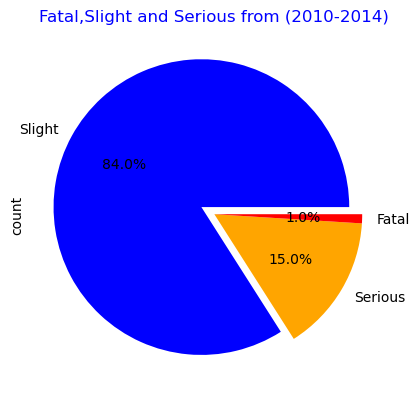

In [207]:
# Generate a pie plot showing the distribution of Fatal,slight,Serious accidents using Pandas
accident_data =year_df["Accident_Severity"].value_counts()
# Define custom colors
colors = ['blue', 'orange', 'red']

# Define explode values (0 for no explosion, >0 for separation)
explode = (0.1, 0, 0)

plt.title("Fatal,Slight and Serious from (2010-2014)",color='blue')
accident_data.plot.pie(autopct= "%1.1f%%",colors=colors, explode=explode)

#save as png file
plt.savefig("visualisation/maliha_image_piechart.png")
plt.show()

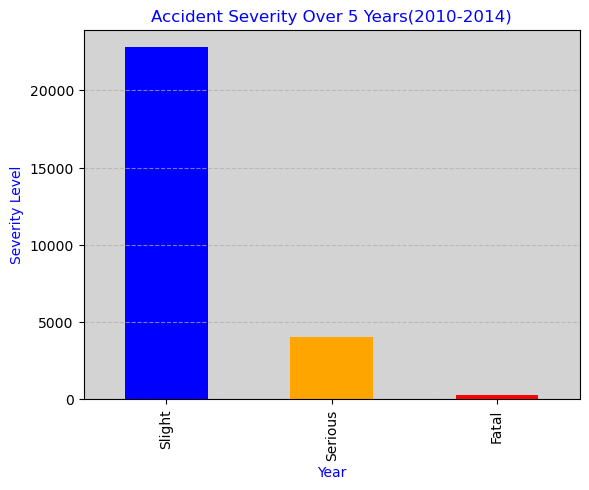

In [208]:
#Bar Chart showing the number of fatal, serious and slight accidents in last 5 years
years = year_df['Date']
severity_counts = year_df['Accident_Severity'].value_counts()

# Group data by year and count the occurrences of each severity level
x_axis =  {'Fatal': ['Fatal'], 
           'Serious':['Serious'], 
           'Slight': ['Slight']}
colors = ['blue', 'orange', 'red'] 
# Create a bar chart
severity_counts.plot(kind='bar', stacked=True,color=colors)

# Set labels and title
plt.xlabel('Year',color='blue')
plt.ylabel('Severity Level',color='blue')
plt.title('Accident Severity Over 5 Years(2010-2014)',color='blue')
# Add a grid
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
# Set background color
plt.gca().set_facecolor('lightgrey')

#save as png file
plt.savefig("visualisation/maliha_image_bar_years.png")

# Display the chart
plt.show()

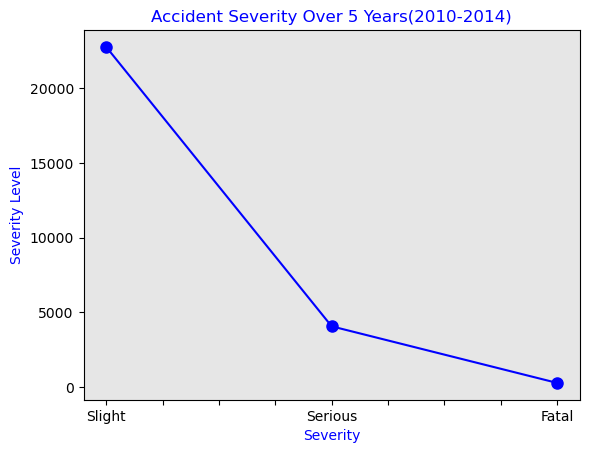

In [209]:
# Line chart showing the accidents by their severity 

x_axis = {'Fatal': ['Fatal'], 
           'Serious':['Serious'], 
           'Slight': ['Slight']}

severity_counts.plot(kind='line', stacked=True,color='blue', marker='o', markersize=8)
# Set labels and title
plt.xlabel('Severity', color='blue')
plt.ylabel('Severity Level', color='blue')
#plt.title('Accident Severity Over 5 Years')
plt.title('Accident Severity Over 5 Years(2010-2014)', color='blue')
ax = plt.gca()
ax.set_facecolor('#e6e6e6')  # Change the color code to your desired background color
#save as png file
plt.savefig("visualisation/maliha_image_line_years.png")
# Display the chart
plt.show()

In [210]:
#making a dataframe including 'Accident_Index', 'Road_Type', 'Accident_Severity',  'Age_Band_of_Driver' to further analysing the data
line_df=year_df[['Accident_Index', 'Road_Type', 'Accident_Severity',  'Age_Band_of_Driver']]
line_df.head()

,Accident_Index,Road_Type,Accident_Severity,Age_Band_of_Driver
41202,201020D002713,6,Slight,9
41203,201020D004613,2,Slight,7
41204,201020D006113,6,Slight,7
41205,201020D006513,6,Slight,-1
41206,201020D006913,6,Slight,-1


In [211]:
#Filtering the column Road_type (roundabouts,dual_carriageway,single_carriageway,single_carriageway=6,slip_road=7) and also for the column "Age Bands of Driver"(21-25)and (46-55)
dual_carriageway = 3
roundabout = 1
oneway_street=2
single_carriageway=6
slip_road=7
age_band_21_25 = 5
age_band_46_55 = 8
newdf = line_df[line_df['Road_Type'].isin([dual_carriageway, roundabout,oneway_street,single_carriageway,slip_road])] 
newdf = line_df[line_df['Age_Band_of_Driver'].isin([age_band_21_25, age_band_46_55])]
newdf

,Accident_Index,Road_Type,Accident_Severity,Age_Band_of_Driver
41219,201020D015712,6,Slight,8
41221,201020D016213,6,Slight,8
41222,201020D017313,6,Serious,5
41224,201020D018013,6,Slight,8
41235,201020D021811,6,Slight,8
...,...,...,...,...
68295,201420Z004524,3,Slight,5
68296,201420Z004584,3,Slight,8
68297,201420Z004594,3,Slight,8
68300,201420Z004724,3,Slight,8


In [212]:
# Mapping the Road_Type categories against their key values 
dual_carriageway = 3
roundabout = 1
oneway_street=2
single_carriageway=6
slip_road=7
type_mapping = {1: 'roundabout',2:'oneway_street',  3: 'dual_carriageway',6:'single_carriageway',7:'slip_road'}
superdf = line_df[line_df['Road_Type'].isin([dual_carriageway, roundabout,oneway_street,single_carriageway,slip_road])]
superdf['Road_Type'] = superdf['Road_Type'].replace(type_mapping)
superdf

C:\Users\HabibRehman\AppData\Local\Temp\ipykernel_28260\1572621885.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  superdf['Road_Type'] = superdf['Road_Type'].replace(type_mapping)


,Accident_Index,Road_Type,Accident_Severity,Age_Band_of_Driver
41202,201020D002713,single_carriageway,Slight,9
41203,201020D004613,oneway_street,Slight,7
41204,201020D006113,single_carriageway,Slight,7
41205,201020D006513,single_carriageway,Slight,-1
41206,201020D006913,single_carriageway,Slight,-1
...,...,...,...,...
68306,201420Z500064,dual_carriageway,Slight,7
68307,201420Z500084,dual_carriageway,Slight,6
68308,201420Z500104,slip_road,Slight,8
68309,201420Z500244,dual_carriageway,Slight,7


In [213]:
#filtering the fatal accidents from Accident severity column
fatal_acc = superdf.loc[superdf["Accident_Severity"]=="Fatal",:]
fatal_acc

,Accident_Index,Road_Type,Accident_Severity,Age_Band_of_Driver
41255,201020D028013,single_carriageway,Fatal,5
41332,201020D053813,single_carriageway,Fatal,6
41373,201020D065612,single_carriageway,Fatal,10
41524,201020E010711,single_carriageway,Fatal,6
41609,201020E026213,single_carriageway,Fatal,7
...,...,...,...,...
67788,201420W046864,dual_carriageway,Fatal,9
67848,201420W052054,dual_carriageway,Fatal,-1
68127,201420Z001254,dual_carriageway,Fatal,4
68185,201420Z002344,dual_carriageway,Fatal,6


In [214]:
# checking the number of fatal accidents on different road types
superdf_count= fatal_acc.groupby(["Road_Type"])["Accident_Severity"].count()
superdf_count.head()

Road_Type
dual_carriageway       78
oneway_street           1
roundabout              9
single_carriageway    179
slip_road               2
Name: Accident_Severity, dtype: int64

In [215]:
severity_counts = year_df['Accident_Severity'].value_counts()

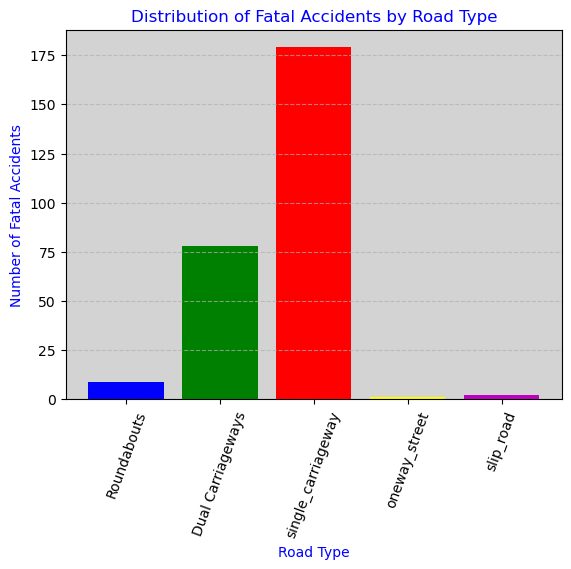

In [216]:
# Define conditions for Road_Types including roundabouts,dual_carriageways,single_carriageway,oneway_street and slip_road
# Fatal accidents distribution on different Road_Types 

condition_roundabout = (superdf['Road_Type'] == 'roundabout') & (superdf['Accident_Severity'] == 'Fatal')
condition_dual_carriageway = (superdf['Road_Type'] == 'dual_carriageway') & (superdf['Accident_Severity'] == 'Fatal')
single_carriageway = (superdf['Road_Type'] == 'single_carriageway') & (superdf['Accident_Severity'] == 'Fatal')
oneway_street = (superdf['Road_Type'] == 'oneway_street') & (superdf['Accident_Severity'] == 'Fatal')
slip_road = (superdf['Road_Type'] == 'slip_road') & (superdf['Accident_Severity'] == 'Fatal')

# Count the number of fatal accidents for each condition

count_roundabout = condition_roundabout.sum()
count_dual_carriageway = condition_dual_carriageway.sum()
count_single_carriageway = single_carriageway.sum()
count_oneway_street = oneway_street.sum()
count_slip_road = slip_road .sum()
# Define labels and counts for the bar chart
x_labels = ['Roundabouts', 'Dual Carriageways','single_carriageway','oneway_street','slip_road']
y_values = [count_roundabout, count_dual_carriageway,count_single_carriageway,count_oneway_street,count_slip_road]

# Create a bar chart
plt.bar(x_labels, y_values, color=['blue', 'green','red','yellow','m'])

# Set labels and title
plt.xlabel('Road Type', color='blue')
plt.ylabel('Number of Fatal Accidents', color='blue')
plt.title('Distribution of Fatal Accidents by Road Type', color='blue')
plt.xticks(rotation=70)
#set grid
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
# Set background color
plt.gca().set_facecolor('lightgrey')
#save as png file
plt.savefig("visualisation/maliha_image_barchart_fatal.png")
# Show the chart
plt.show()


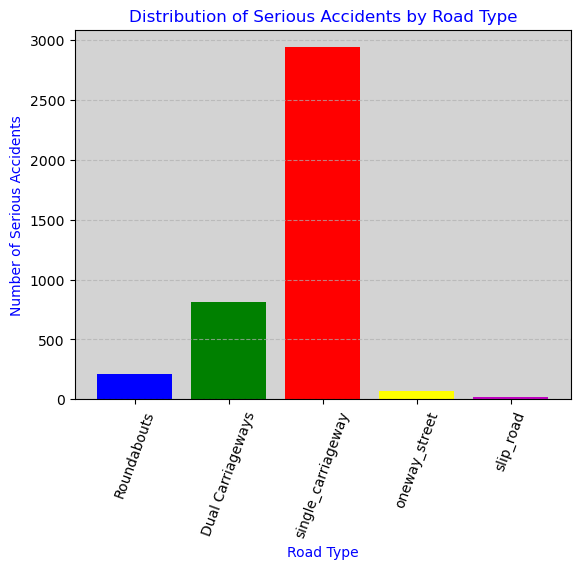

In [217]:
# Define conditions for Road_Types including roundabouts,dual_carriageways,single_carriageway,oneway_street and slip_road
# Serious accidents distribution on different Road_Types 

condition_roundabout1 = (superdf['Road_Type'] == 'roundabout') & (superdf['Accident_Severity'] == 'Serious')
condition_dual_carriageway1 = (superdf['Road_Type'] == 'dual_carriageway') & (superdf['Accident_Severity'] == 'Serious')
single_carriageway1 = (superdf['Road_Type'] == 'single_carriageway') & (superdf['Accident_Severity'] == 'Serious')
oneway_street1 = (superdf['Road_Type'] == 'oneway_street') & (superdf['Accident_Severity'] == 'Serious')
slip_road1 = (superdf['Road_Type'] == 'slip_road') & (superdf['Accident_Severity'] == 'Serious')
# Count the number of accidents for each condition
count_roundabout1 = condition_roundabout1.sum()
count_dual_carriageway1 = condition_dual_carriageway1.sum()
count_single_carriageway1 = single_carriageway1.sum()
count_oneway_street1= oneway_street1.sum()
count_slip_road1 = slip_road1 .sum()
# Define labels and counts for the bar chart
x_labels = ['Roundabouts', 'Dual Carriageways','single_carriageway','oneway_street','slip_road']
y_values = [count_roundabout1, count_dual_carriageway1,count_single_carriageway1,count_oneway_street1,count_slip_road1]

# Create a bar chart
plt.bar(x_labels, y_values, color=['blue', 'green','red','yellow','m'])

# Set labels and title
plt.xlabel('Road Type', color='blue')
plt.ylabel('Number of Serious Accidents', color='blue')
plt.title('Distribution of Serious Accidents by Road Type', color='blue')
plt.xticks(rotation=70)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
# Set background color
plt.gca().set_facecolor('lightgrey')
#save as png file
plt.savefig("visualisation/maliha_image_barchart_Serious.png")
# Show the chart
plt.show()

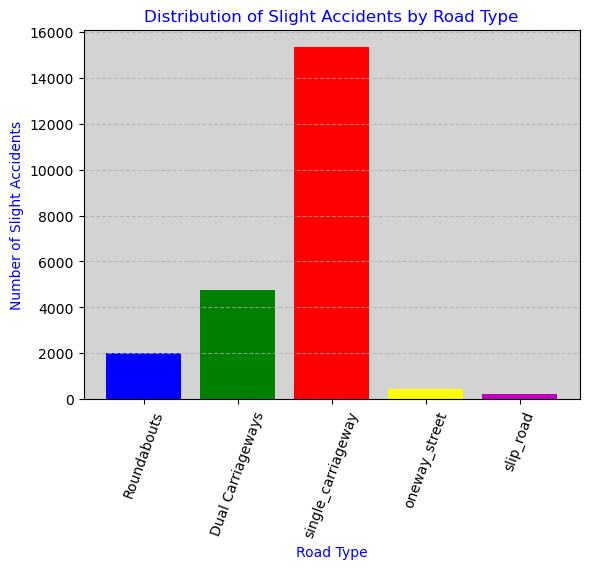

In [218]:
# Define conditions for Road_Types including roundabouts,dual_carriageways,single_carriageway,oneway_street and slip_road
# Slight accidents distribution on different Road_Types 

condition_roundabout2 = (superdf['Road_Type'] == 'roundabout') & (superdf['Accident_Severity'] == 'Slight')
condition_dual_carriageway2 = (superdf['Road_Type'] == 'dual_carriageway') & (superdf['Accident_Severity'] == 'Slight')
single_carriageway2 = (superdf['Road_Type'] == 'single_carriageway') & (superdf['Accident_Severity'] == 'Slight')
oneway_street2 = (superdf['Road_Type'] == 'oneway_street') & (superdf['Accident_Severity'] == 'Slight')
slip_road2 = (superdf['Road_Type'] == 'slip_road') & (superdf['Accident_Severity'] == 'Slight')

# Count the number of accidents for each condition

count_roundabout2 = condition_roundabout2.sum()
count_dual_carriageway2 = condition_dual_carriageway2.sum()
count_single_carriageway2 = single_carriageway2.sum()
count_oneway_street2= oneway_street2.sum()
count_slip_road2 = slip_road2 .sum()

# Define labels and counts for the bar chart

x_labels = ['Roundabouts', 'Dual Carriageways','single_carriageway','oneway_street','slip_road']
y_values = [count_roundabout2, count_dual_carriageway2,count_single_carriageway2,count_oneway_street2,count_slip_road2]

# Create a bar chart
plt.bar(x_labels, y_values, color=['blue', 'green','red','yellow','m'])

# Set labels and title
plt.xlabel('Road Type', color='blue')
plt.ylabel('Number of Slight Accidents', color='blue')
plt.title('Distribution of Slight Accidents by Road Type', color='blue')
plt.xticks(rotation=70)

#Set grid
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Set background color
plt.gca().set_facecolor('lightgrey')
#save as png file
plt.savefig("visualisation/maliha_image_barchart_Slight.png")

# Show the chart
plt.show()

# Saki_notebook

In [219]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import time
from datetime import datetime


In [220]:
working_df= pd.read_csv("cleaned_car_accidents.csv")
working_df.head()

,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),...,Vehicle_Reference_y,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Car_Passenger,Casualty_Type,Casualty_Home_Area_Type
0,200520D002602,-1.832342,52.534986,2,1,3,01/01/2005,7,20:23,300,...,1,1,1,1,-1,-1,3,0,9,1
1,200520D002703,-1.846293,52.465961,3,2,2,02/01/2005,1,18:45,300,...,2,1,1,1,31,6,3,0,9,1
2,200520D004203,-1.794089,52.455003,3,1,1,03/01/2005,2,17:04,300,...,1,1,1,1,24,5,3,0,9,1
3,200520D004603,-1.869954,52.478755,1,1,2,05/01/2005,4,15:05,300,...,1,1,3,1,31,6,1,0,0,1
4,200520D006503,-1.857470,52.469211,3,2,1,05/01/2005,4,22:00,300,...,2,1,1,2,22,5,3,0,9,1


In [221]:
working_df.shape

(68311, 55)

In [222]:
working_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68311 entries, 0 to 68310
Data columns (total 55 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Accident_Index                           68311 non-null  object 
 1   Longitude                                68311 non-null  float64
 2   Latitude                                 68311 non-null  float64
 3   Accident_Severity                        68311 non-null  int64  
 4   Number_of_Vehicles                       68311 non-null  int64  
 5   Number_of_Casualties                     68311 non-null  int64  
 6   Date                                     68311 non-null  object 
 7   Day_of_Week                              68311 non-null  int64  
 8   Time                                     68311 non-null  object 
 9   Local_Authority_(District)               68311 non-null  int64  
 10  1st_Road_Class                           68311

In [223]:
working_df.describe()

,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),1st_Road_Class,1st_Road_Number,Road_Type,...,Vehicle_Reference_y,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Car_Passenger,Casualty_Type,Casualty_Home_Area_Type
count,68311.000000,68311.000000,68311.000000,68311.000000,68311.000000,68311.000000,68311.000000,68311.000000,68311.000000,68311.000000,...,68311.000000,68311.000000,68311.000000,68311.000000,68311.000000,68311.000000,68311.000000,68311.000000,68311.000000,68311.000000
mean,-1.897209,52.492207,2.856451,1.850288,1.371624,4.118678,302.792786,4.463161,1268.857007,4.931138,...,1.470232,1.026496,1.551068,1.392250,32.474389,5.764899,2.870343,0.125836,6.496289,0.940449
std,0.172846,0.060632,0.376019,0.670148,0.817911,1.924740,3.099256,1.497184,1871.996418,1.713476,...,0.528104,0.206966,0.823011,0.488256,18.517720,2.484937,0.358852,0.413438,6.727738,0.534120
min,-2.203214,52.348078,1.000000,1.000000,1.000000,1.000000,300.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000,-1.000000
25%,-2.013377,52.447660,3.000000,1.000000,1.000000,2.000000,300.000000,3.000000,0.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,20.000000,4.000000,3.000000,0.000000,1.000000,1.000000
50%,-1.910877,52.485477,3.000000,2.000000,1.000000,4.000000,302.000000,4.000000,34.000000,6.000000,...,1.000000,1.000000,1.000000,1.000000,29.000000,6.000000,3.000000,0.000000,9.000000,1.000000
75%,-1.830438,52.531750,3.000000,2.000000,1.000000,6.000000,305.000000,6.000000,4040.000000,6.000000,...,2.000000,1.000000,2.000000,2.000000,44.000000,7.000000,3.000000,0.000000,9.000000,1.000000
max,-1.428223,52.662124,3.000000,12.000000,42.000000,7.000000,309.000000,6.000000,5127.000000,9.000000,...,9.000000,6.000000,3.000000,2.000000,100.000000,11.000000,3.000000,2.000000,90.000000,3.000000


In [224]:
unique =working_df["Vehicle_Type"].unique()
unique

array([ 9, 11, 21,  8, 20,  2, 19,  4,  1, 90,  3,  5, 10, 17],
      dtype=int64)

In [225]:
#Determining the type of vehicle involved in an accident, and the severity impact of the accident
severity_by_vehicle_type = working_df.groupby(['Vehicle_Type','Accident_Severity']).size()
severity_by_vehicle_type

Vehicle_Type  Accident_Severity
1             1                       18
              2                      359
              3                     1789
2             1                        3
              2                      105
              3                      394
3             1                        9
              2                      256
              3                      611
4             1                        8
              2                       85
              3                      158
5             1                       47
              2                      306
              3                      462
8             1                       11
              2                      217
              3                     1582
9             1                      419
              2                     6316
              3                    46705
10            1                        3
              2                       32
              3          

In [226]:
#total number of vehicles involved in an accident
total_vehicles = working_df.groupby('Accident_Index',)['Number_of_Vehicles'].sum()
total_vehicles

Accident_Index
200520D002602    1
200520D002703    2
200520D004203    1
200520D004603    1
200520D006503    2
                ..
201420Z500064    1
201420Z500084    2
201420Z500104    2
201420Z500244    2
201420Z625594    2
Name: Number_of_Vehicles, Length: 68311, dtype: int64

In [227]:
#Defining the type_mapping dictionary
type_mapping = {
1: 'Pedal cycle',                    
2:'Motorcycle 50cc and under',            
3:'Motorcycle 125cc and under',           
4:'Motorcycle over 125cc and up to 500cc', 
5:'Motorcycle over 500cc',                
8:'Taxi/Private hire car',               
9:'Car',                                  
10:'Minibus (8 - 16 passenger seats)',     
11:'Bus or coach (17 or more pass seats)', 

16:'Ridden horse',                       
17:'Agricultural vehicle',                
18:'Tram',                                
19:'Van / Goods 3.5 tonnes mgw or under',
20:'Goods over 3.5t. and under 7.5t',      
21:'Goods 7.5 tonnes mgw and over',       
22:'Mobility scooter',                   
23:'ElecElectric motorcycle',              
90:'Other vehicle',                   
97:'Motorcycle - unknown cc',
98:'Goods vehicle - unknown weight',      
-1:'Data missing or out of range',        
}

type_mapping = {1:'Pedal cycle', 2:'Motorcycle 50cc and under', 3:'Motorcycle 125cc and under', 
                4:'Motorcycle over 125cc and up to 500cc', 5:'Motorcycle over 500cc', 8:'Taxi/Private hire car',
                9:'Car', 10: 'Minibus (8 - 16 passenger seats)', 11:'Bus or coach (17 or more pass seats)',
                16:'Ridden horse', 17:'Agricultural vehicle', 18:'Tram', 19:'Van / Goods 3.5 tonnes mgw or under',
                20:'Goods over 3.5t. and under 7.5t', 21:'Goods 7.5 tonnes mgw and over', 22:'Mobility scooter',
                23:'Electric motorcycle', 90:'Other vehicle', 97:'Motorcycle - unknown cc', 98:'Goods vehicle - unknown weight',
                -1:'Data missing or out of range'}
vehicle_df = working_df[working_df['Vehicle_Type'].isin(type_mapping.keys())]
vehicle_df['Vehicle_Type']=vehicle_df['Vehicle_Type'].replace(type_mapping)
vehicle_df

,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),...,Vehicle_Reference_y,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Car_Passenger,Casualty_Type,Casualty_Home_Area_Type
0,200520D002602,-1.832342,52.534986,2,1,3,01/01/2005,7,20:23,300,...,1,1,1,1,-1,-1,3,0,9,1
1,200520D002703,-1.846293,52.465961,3,2,2,02/01/2005,1,18:45,300,...,2,1,1,1,31,6,3,0,9,1
2,200520D004203,-1.794089,52.455003,3,1,1,03/01/2005,2,17:04,300,...,1,1,1,1,24,5,3,0,9,1
3,200520D004603,-1.869954,52.478755,1,1,2,05/01/2005,4,15:05,300,...,1,1,3,1,31,6,1,0,0,1
4,200520D006503,-1.857470,52.469211,3,2,1,05/01/2005,4,22:00,300,...,2,1,1,2,22,5,3,0,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68306,201420Z500064,-1.937139,52.552170,3,1,1,21/12/2014,1,18:05,305,...,1,1,3,1,44,7,3,0,0,1
68307,201420Z500084,-1.852342,52.505975,3,2,3,23/12/2014,3,18:30,300,...,1,1,1,1,28,6,3,0,9,1
68308,201420Z500104,-1.860138,52.509850,3,2,1,28/12/2014,1,16:45,300,...,2,1,1,2,54,8,3,0,9,1
68309,201420Z500244,-1.871192,52.509054,3,2,2,04/09/2014,5,09:20,300,...,1,1,1,1,40,7,3,0,19,-1


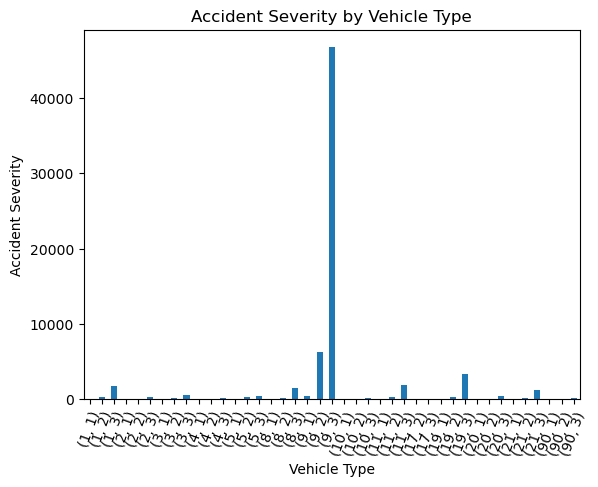

<Figure size 640x480 with 0 Axes>

In [228]:
# create a bar chat
severity_by_vehicle_type.plot(kind='bar')
plt.title('Accident Severity by Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Accident Severity')
plt.xticks(rotation=70)


plt.show()

#save as png file
plt.savefig("visualisation/saki_barchart.png")


In [229]:
severity_mapping = {1:'High', 2:'Medium', 3:'Low'}

#Apply the mapping using replace()
working_df['Accident_Severity'] = working_df['Accident_Severity'].replace(severity_mapping)
working_df

,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),...,Vehicle_Reference_y,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Car_Passenger,Casualty_Type,Casualty_Home_Area_Type
0,200520D002602,-1.832342,52.534986,Medium,1,3,01/01/2005,7,20:23,300,...,1,1,1,1,-1,-1,3,0,9,1
1,200520D002703,-1.846293,52.465961,Low,2,2,02/01/2005,1,18:45,300,...,2,1,1,1,31,6,3,0,9,1
2,200520D004203,-1.794089,52.455003,Low,1,1,03/01/2005,2,17:04,300,...,1,1,1,1,24,5,3,0,9,1
3,200520D004603,-1.869954,52.478755,High,1,2,05/01/2005,4,15:05,300,...,1,1,3,1,31,6,1,0,0,1
4,200520D006503,-1.857470,52.469211,Low,2,1,05/01/2005,4,22:00,300,...,2,1,1,2,22,5,3,0,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68306,201420Z500064,-1.937139,52.552170,Low,1,1,21/12/2014,1,18:05,305,...,1,1,3,1,44,7,3,0,0,1
68307,201420Z500084,-1.852342,52.505975,Low,2,3,23/12/2014,3,18:30,300,...,1,1,1,1,28,6,3,0,9,1
68308,201420Z500104,-1.860138,52.509850,Low,2,1,28/12/2014,1,16:45,300,...,2,1,1,2,54,8,3,0,9,1
68309,201420Z500244,-1.871192,52.509054,Low,2,2,04/09/2014,5,09:20,300,...,1,1,1,1,40,7,3,0,19,-1


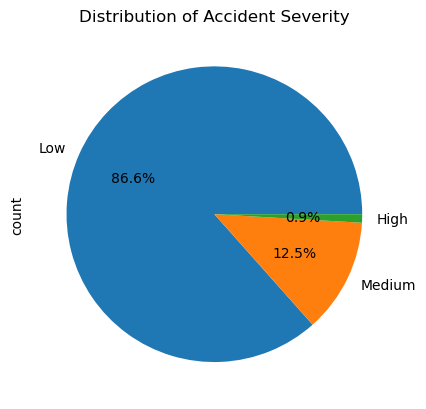

<Figure size 640x480 with 0 Axes>

In [230]:

#Generate a pie plot showing the allocation of High, Medium and low accident using pandas
accident_data=working_df["Accident_Severity"].value_counts()
plt.title("Distribution of Accident Severity")
accident_data.plot.pie(autopct="%1.1f%%")

plt.show()

#save as png file
plt.savefig("visualisation/saki_piechart.png")
